# Figure 7: QSD for the 30 mosquito model with no reversion

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Importing required libraries

In [1]:
import numpy as np
import itertools
import pylab as plt
import matplotlib

Importing required scripts

In [2]:
import importlib
import Rate_transitions
import Finding_full_Q
import Tridiagonalisation
import Finding_sub_Q
import Lower_block_triangular
import Finding_dictionary_keys
import Hughes_model

get_transition = Rate_transitions.get_transition_Hughes
getQ = Finding_full_Q.getQ_Hughes
tridiagonal = Tridiagonalisation.tridiagonal
getQk = Finding_sub_Q.getQk_Hughes
LBTQ = Lower_block_triangular.LBTQ_Hughes_comp
find_keys = Finding_dictionary_keys.find_keys
F = Hughes_model.F_hughes

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

Parameter values

In [3]:
K = 30        # reproductive carrying capacity
d1 = 12/100   # wild-type death rate
d2 = 12/100   # Wolbachia death rate
phi = 9/10    # Wolbachia fitness

v = 10/10     # probability of vertical transmission
u = 10/10     # ratio of unviable offspring produced by an infected male and uninfected female

k = 0.3           # Mosquito competition parameter
h = 0.19*100**k   # Mosquito competition parameter

b1 = round(d1/F(10,h,k),2) # wild-type per capita birth rate
b2 = b1*phi                # Wolbachia per capita birth rate

# create a dictionary to store all parameter values
params_dict = {'b1': b1,
              'b2': b2,
              'K': K,
              'd1': d1,
              'd2': d2,
              'v': v,
              'phi': phi,
              'u': u,
              'h': h,
              'k': k
              }

Construct a dictionary of all the state variables

In [4]:
# construct a dictionary that associated an integer index with each possible states, states are stored as an np.array - easier to apply mathematical operations than tuple 
max_pop = 30   # maximum household size
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}

Construct the full transition matrix

In [5]:
# construct a matrix Q for the transition rate q_ij betweeen states i and j
n_states = len(state_dict)   # total number of states

Q = getQ(state_dict,params_dict)
print(Q)

[[-0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.12       -0.34810476  0.22810476 ...  0.          0.
   0.        ]
 [ 0.          0.24       -0.62303015 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -5.4419426   0.
   1.9619426 ]
 [ 0.          0.          0.         ...  0.12       -3.6
   0.        ]
 [ 0.          0.          0.         ...  3.6         0.
  -3.6       ]]


Constructing individual dictionaries of the communicating state classes and their respective sub-Q matrices

In [6]:
### S1 corresponds to the wild-type-only states, S2 to the Wolbachia-only and S3 the mixed states
state_dict_S1 = {index: np.array((i, 0)) for index, i in enumerate([i for i in range(1,max_pop + 1)])}
state_dict_S2 = {index: np.array((0, i)) for index, i in enumerate([i for i in range(1,max_pop + 1)])}
state_dict_S3 = {index: np.array((i,j)) for index, (i,j) in enumerate([(i, j) for i in range(1,max_pop + 1) for j in range(1,max_pop + 1) if i + j <= max_pop])}

# finding the sub-q matrices and their respective ordered lists of states in the class
# we will use these list to rearrange Q into lower block triangular form
Q1,key_list1 = getQk(state_dict_S1,state_dict,Q,params_dict)
Q2,key_list2 = getQk(state_dict_S2,state_dict,Q,params_dict)
Q3,key_list3 = getQk(state_dict_S3,state_dict,Q,params_dict)

Putting Q in lower block triangular form and constructing the reordered full state dictionary

In [7]:
Q_lower_block_triang, state_dict_relabel = LBTQ(Q,state_dict,state_dict_S1,state_dict_S2,state_dict_S3,max_pop,params_dict)
print('Q in lower block triangular form is:', Q_lower_block_triang)

Q in lower block triangular form is: [[-0.37344973  0.25344973  0.         ...  0.          0.
   0.        ]
 [ 0.24       -0.66558906  0.42558906 ...  0.          0.
   0.        ]
 [ 0.          0.36       -0.92593884 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -5.36985696  0.06088787
   1.82896908]
 [ 0.          0.          0.         ...  0.24       -3.6
   0.        ]
 [ 0.          0.          0.         ...  3.48        0.
  -3.6       ]]


Calculate the eigenvalues of Q and find the largest (minimal magitude, all are negative), the decay parameter

In [8]:
evals, evecs = np.linalg.eig(Q_lower_block_triang.T)
decay_param = np.max([x for x in evals if x != 0])
print(decay_param)

(-0.002436712685611981+0j)


Checking S1 holds the overall eigenvalue of minimal magnitude

In [9]:
evals1, evecs1 = np.linalg.eig(Q1.T)
decay_param1 = np.max([x for x in evals1 if x != 0])
print('minimal magnitude eigenvalue of Q1', decay_param1)

evals2, evecs2 = np.linalg.eig(Q2.T)
decay_param2 = np.max([x for x in evals2 if x != 0])
print('minimal magnitude eigenvalue of Q2', decay_param2)

evals3, evecs3 = np.linalg.eig(Q3.T)
decay_param3 = np.max([x for x in evals3 if x != 0])
print('minimal magnitude eigenvalue of Q3', decay_param3)

minimal magnitude eigenvalue of Q1 -0.002436712685611981
minimal magnitude eigenvalue of Q2 -0.004793904572381276
minimal magnitude eigenvalue of Q3 (-0.07904678215414251+0j)


Constructing the QSD

In [10]:
decay_indx = np.argmax([x for x in evals if x != 0])
uvec = evecs[:,decay_indx]
quasi_stat_dist = uvec/np.sum(uvec)

Finding the non-zero QSD values and recording their respective states. All non-zero probabilities are wild-type-only states.

In [11]:
dist_indxs = np.where(quasi_stat_dist > 1e-16)[0]  # extracting indices of non-zero values
states = np.zeros((len(dist_indxs),2))   # initialising an array to record the states
dist = np.zeros(len(dist_indxs))         # initialising an array to record the QSD values

for i in range(len(dist_indxs)):      # looping over all the non-zero entries
    indx = dist_indxs[i]                    # current index
    states[i,:] = state_dict_relabel[indx]  # recording state corresponds to
    dist[i] = quasi_stat_dist[indx]         # recording QSD value corresponds to

C:\Users\abby2\AppData\Local\Temp/ipykernel_1220/1428129494.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[i] = quasi_stat_dist[indx]         # recording QSD value corresponds to


Plotting the figure

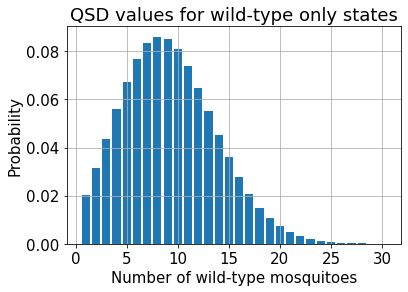

In [12]:
matplotlib.rcParams.update({'font.size': 15})  # font size
values = np.arange(1,31,1)    # numbers of wild-types 
plt.bar(values,dist)          # plot the distribution as a bar chart
plt.xlabel('Number of wild-type mosquitoes')    # x label
plt.ylabel('Probability')                       # y label
plt.title('QSD values for wild-type only states')   # title
plt.grid()   # makes grid
plt.savefig('qsd_30_dye_v09.pdf', bbox_inches='tight')   # save figure

The sojourn time is

In [13]:
soj_time = 0
for i in range(n_states-1):
    soj_time -= quasi_stat_dist[i]/Q_lower_block_triang[i,i]
print('expected time spent in a state is', soj_time)

expected time spent in a state is (0.5753760617492162+0j)


Damping ratio calculations

In [14]:
damp_ratio = np.exp(decay_param1-decay_param2) # damping ratio
print('the damping ratio is', damp_ratio)
print('The expected time until total probability mass of the wild-type-only states are')
print('10 times greater', np.log(10)/np.log(damp_ratio))
print('100 times greater', np.log(100)/np.log(damp_ratio))
print('1000 times greater', np.log(1000)/np.log(damp_ratio))

the damping ratio is 1.0023599722477503
The expected time until total probability mass of the wild-type-only states are
10 times greater 976.8339632926546
100 times greater 1953.6679265853093
1000 times greater 2930.5018898779635
